# Balencing Data

Dataset yang tidak seimbang dapat menimbulkan bias pada model machine learning, di mana model lebih condong mengenali kelas mayoritas dan mengabaikan kelas minoritas. Untuk mengatasi hal ini, digunakan metode ADASYN (Adaptive Synthetic Sampling) yang secara adaptif menghasilkan data sintetis baru pada kelas minoritas, khususnya di area yang sulit dipelajari model.

Notebook ini bertujuan menunjukkan bagaimana [**Data ecoli**](https://archive.ics.uci.edu/dataset/39/ecoli) yang awalnya tidak seimbang dapat diseimbangkan dengan ADASYN, serta membandingkan distribusi data sebelum dan sesudah balancing melalui scatter plot. Dengan proses ini, model diharapkan mampu memberikan prediksi yang lebih adil dan akurat pada semua kelas.

## Import Library Pendukung

In [1]:
!pip install pymysql python-dotenv imbalanced-learn pandas matplotlib seaborn

In [2]:
import pymysql
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN

ModuleNotFoundError: No module named 'dotenv'

## Koneksi MySQL dan Ambil Data

Data ecoli yang digunakan telah diimport ke DMBS MySQL, oleh karena itu perlu untuk mengkoneksikan file ipynb ini dengan DBMS MySQL. Code di bawah menunjukkan cara untuk koneksi database menggunakan modul pymysql yang sudah diinstall di tahap awal. Demi keamanan, penulis menggunakan environment variabel untuk membinding kredensial database yang digunakan. 

In [29]:
load_dotenv()

host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASS")
db = os.getenv("DB_NAME")

conn = pymysql.connect(
  host = host,
  port = int(port),
  user = user,
  password = password,
  database = db,
)

query = "SELECT * FROM ecoli.data_ecoli"

df = pd.read_sql(query, conn)
conn.close()

C:\Users\Muhammad Junaidi\AppData\Local\Temp\ipykernel_1844\339049370.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Cek distribusi kelas

Code di bawah ini berfungsi untuk mengecek distribusi kelas pada dataset ecoli dan sample terkecil dari kelas minoritas. Karena sample terkecil adalah 2 maka n_neighbors atau k yang bisa digunakan adalah satu yang mana sample tersebut hanya memiliki 1 tetangga.  

In [30]:
print("Distribusi kelas sebelum balancing:")
print(df['class'].value_counts())

# Ambil jumlah minimum sampel di kelas minoritas
min_class_count = df['class'].value_counts().min()
print(f"\nJumlah sampel paling sedikit di kelas minoritas: {min_class_count}")

# Tentukan n_neighbors otomatis (harus < min_class_count)
n_neighbors = max(1, min_class_count - 1)
print(f"n_neighbors yang dipakai untuk ADASYN: {n_neighbors}")

Distribusi kelas sebelum balancing:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64

Jumlah sampel paling sedikit di kelas minoritas: 2
n_neighbors yang dipakai untuk ADASYN: 1


## Plotting

Plotting ini bertujuan untuk membuat visualisasi perbandingkan sebelum dan sesudah data balencing menggunakan ADASYN.

In [38]:
X = df[['mcg', 'gvh']]
y = df['class']

# Jumlah data asli
n_original = len(X)

# Terapkan ADASYN
adasyn = ADASYN(n_neighbors=n_neighbors, random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)

# Dataframe hasil balancing
df_res = pd.DataFrame(X_res, columns=['mcg', 'gvh'])
df_res['class'] = y_res

# Menandai mana data asli dan mana hasil generate
df_res['status'] = ['original'] * n_original + ['synthetic'] * (len(X_res) - n_original)

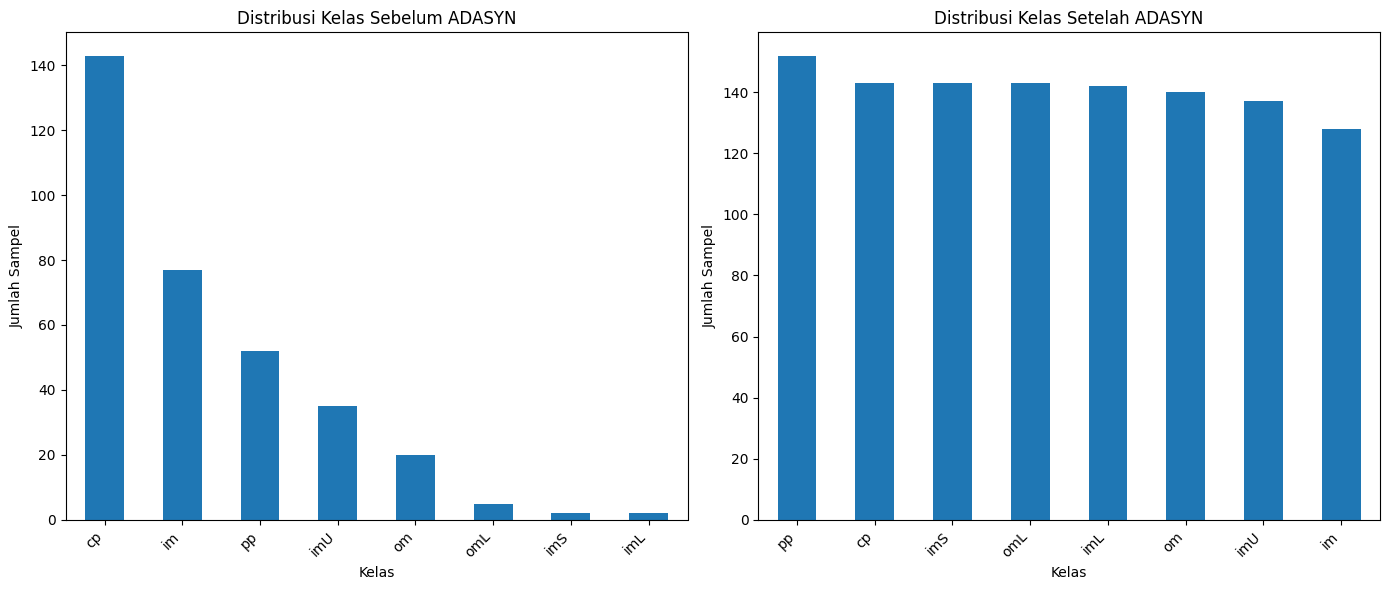

In [32]:
# Visualisasi distribusi kelas sebelum balancing
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df['class'].value_counts().plot(kind='bar')
plt.title('Distribusi Kelas Sebelum ADASYN')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45, ha='right')

# Visualisasi distribusi kelas setelah balancing
plt.subplot(1, 2, 2)
df_res['class'].value_counts().plot(kind='bar')
plt.title('Distribusi Kelas Setelah ADASYN')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [35]:
print("Distribusi kelas sebelum balancing:")
print(df['class'].value_counts())

print("\nDistribusi kelas sesudah balancing:")
print(df_res['class'].value_counts())

Distribusi kelas sebelum balancing:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64

Distribusi kelas sesudah balancing:
class
pp     152
cp     143
imS    143
omL    143
imL    142
om     140
imU    137
im     128
Name: count, dtype: int64


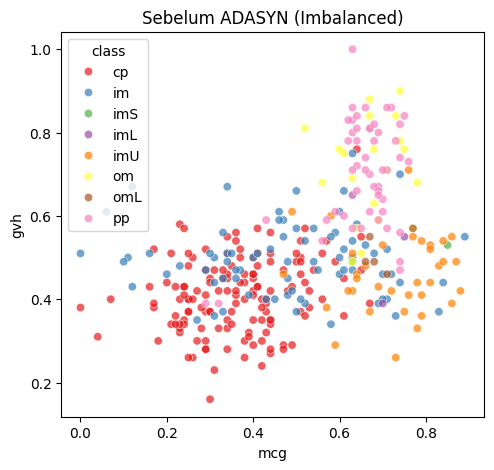

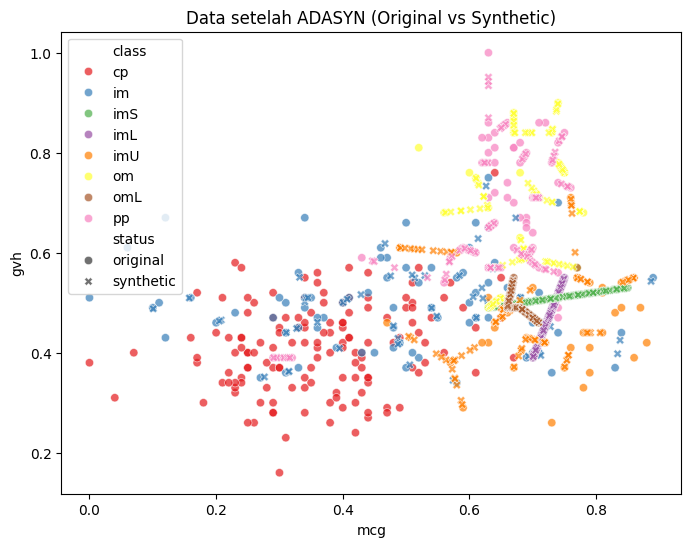

In [37]:
# Plot sebelum balancing
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='mcg', y='gvh', hue=y, data=df, palette='Set1', alpha=0.7)
plt.title("Sebelum ADASYN (Imbalanced)")

plt.figure(figsize=(8,6))
sns.scatterplot(x='mcg', y='gvh', hue='class', style='status',
                data=df_res, palette='Set1', alpha=0.7)
plt.title("Data setelah ADASYN (Original vs Synthetic)")
plt.show()

Pada visualisasi data scatter plot sesudah menerapkan ADASYN, data original ditandai sebagai tanda dot atau lingkaran sedangkan data sintetis atau hasil generate ditandai dengan simbol silang atau x.